In [1]:
%matplotlib inline
import sys
import emcee
from astropy import table
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import betterplotlib as bpl

bpl.set_style()

In [2]:
sys.path.append(str(Path("..").resolve() / "analysis" / "mass_radius_relation"))
import mass_radius_utils as mru
import mass_radius_utils_mcmc_fitting as mru_mcmc
import mass_radius_utils_mle_fitting as mru_mle
import mass_radius_utils_plotting as mru_p

In [3]:
# galaxy = "ngc628-e"
# data_dir = Path("..").resolve() / "data" / galaxy / "size"
# catalog_loc = data_dir / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
# big_catalog = table.Table.read(str(catalog_loc), format="ascii.ecsv")

data_dir = Path("..").resolve() / "data"
catalogs = []
for galaxy_dir in sorted(data_dir.iterdir()):
    cat_name = galaxy_dir / "size" / "final_catalog_final_30_pixels_psf_my_stars_15_pixels_2x_oversampled.txt"
    final_cat = table.Table.read(str(cat_name), format="ascii.ecsv")
#     final_cat["distance"] = utils.distance(galaxy_dir).to("Mpc").value
    final_cat["galaxy"] = galaxy_dir.name
    
    catalogs.append(final_cat)
    
big_catalog = table.vstack(catalogs, join_type="outer")

/Users/gillenb/miniconda3/envs/legus/lib/python3.8/site-packages/astropy/table/table.py:1651: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
  self.columns[item][:] = value


In [4]:
# ======================================================================================
#
# start parsing my catalogs
#
# ======================================================================================
# then filter out some clusters
print(f"Total Clusters: {len(big_catalog)}")
mask = big_catalog["good"]

# mask = np.logical_and(mask, big_catalog["age_yr"] <= 200e6)
# print(f"Clusters with age < 200 Myr: {np.sum(mask)}")

mask = np.logical_and(mask, big_catalog["good"])
print(f"Clusters with good fits: {np.sum(mask)}")

mask = np.logical_and(mask, big_catalog["mass_msun"] > 0)
mask = np.logical_and(mask, big_catalog["mass_msun_max"] > 0)
mask = np.logical_and(mask, big_catalog["mass_msun_min"] > 0)
print(f"Clusters with good masses: {np.sum(mask)}")

mask = np.logical_and(mask, big_catalog["ID"] < 10)
# mask = np.logical_and(mask, big_catalog["mass_msun"] < 1e5)
print(f"Clusters used for fitting: {np.sum(mask)}")

mass, mass_err_lo, mass_err_hi = mru.get_my_masses(big_catalog, mask)
r_eff, r_eff_err_lo, r_eff_err_hi = mru.get_my_radii(big_catalog, mask)
ids = big_catalog["ID"][mask]
galaxies = big_catalog["galaxy"][mask]

Total Clusters: 7242
Clusters with good fits: 6097
Clusters with good masses: 5987
Clusters used for fitting: 55


In [5]:
best_fit, samples = mru_mcmc.fit_mass_size_relation(
    mass, mass_err_lo, mass_err_hi,
    r_eff, r_eff_err_lo, r_eff_err_hi,
    100, 100
)

In [6]:
# mru_p.mcmc_plots(samples,
#                  mass_legus, mass_err_lo_legus, mass_err_hi_legus, 
#                  r_eff_legus, r_eff_err_lo_legus, r_eff_err_hi_legus,
#                  ids, galaxies,
#                  None, None)

In [7]:
fit_mle, fit_history_mle = mru_mle.fit_mass_size_relation(
    mass,
    mass_err_lo,
    mass_err_hi,
    r_eff,
    r_eff_err_lo,
    r_eff_err_hi,
    fit_mass_upper_limit=1e5,
)

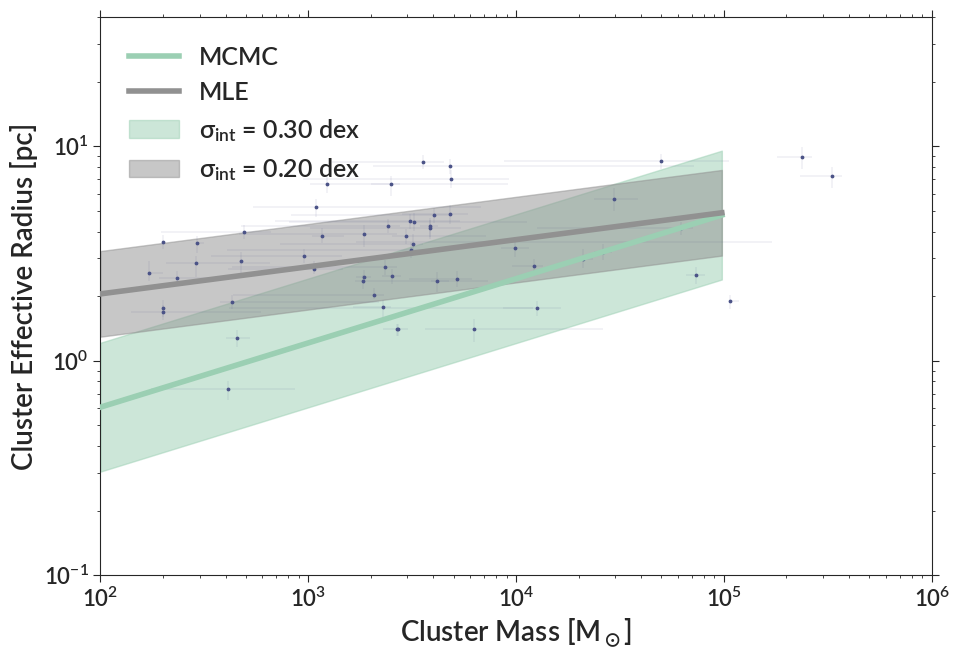

In [8]:
fig, ax = bpl.subplots()
mru_p.plot_mass_size_dataset_scatter(
    ax,
    mass,
    mass_err_lo,
    mass_err_hi,
    r_eff,
    r_eff_err_lo,
    r_eff_err_hi,
    bpl.color_cycle[0],
)
# mru_p.add_percentile_lines(ax, mass, r_eff)
mru_p.plot_best_fit_line(ax, best_fit, 1e2, 1e5, label="MCMC", color=bpl.color_cycle[1])
mru_p.plot_best_fit_line(ax, fit_mle, 1e2, 1e5, label="MLE", color=bpl.color_cycle[2])
mru_p.format_mass_size_plot(ax)